<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

В нашем распоряжении набор фотографий людей с указанием возраста.

# Цель исследования

Построить модель, которая по фотографии определит приблизительный возраст человека. Добиться метрики MAE на тестовой выборке не больше 8.

# Описание данных

Данные взяты с сайта [ChaLearn Looking at People](https://chalearnlap.cvc.uab.cat/dataset/26/description/).

В нашем распоряжении одна папка со всеми изображениями и CSV-файл с двумя колонками:
- `file_name` - имя файла
- `real_age` - возраст человека на фото

# Этапы исследования

1.  Исследовательский анализ данных
2.  Обучение модели
3.  Анализ обученной модели

## Исследовательский анализ данных

In [ ]:
# импортируем нужные библиотеки

import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# загружаем данные

labels = pd.read_csv('***')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='***',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Всего 7591 изображение.

In [ ]:
# выведем 10 случайных строк

labels.sample(10)

,file_name,real_age
5782,005782.jpg,58
739,000739.jpg,25
4268,004268.jpg,30
823,000823.jpg,27
6707,006714.jpg,60
5833,005833.jpg,14
3921,003921.jpg,31
3622,003622.jpg,36
2554,002554.jpg,17
5236,005236.jpg,30


In [ ]:
# посмотрим общую информацию о датасете

labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
# делим выборку на признаки и целевой признак

features, target = next(train_gen_flow)

In [ ]:
features.shape

(32, 224, 224, 3)

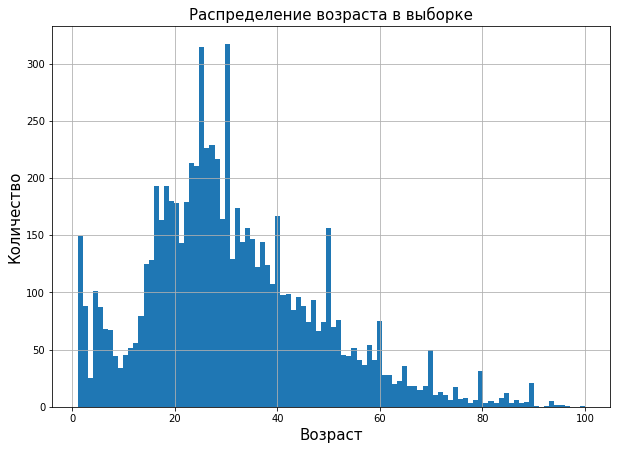

In [ ]:
# построим график распределения возраста в выборке

labels.real_age.hist(bins=100, figsize=(10,7))
plt.title('Распределение возраста в выборке', fontsize=15)
plt.xlabel('Возраст', fontsize=15)
plt.ylabel('Количество', fontsize=15);

In [ ]:
# вычислим 2 заметные моды в данных

labels.real_age.value_counts().head(2)

30    317
25    315
Name: real_age, dtype: int64

Распределение близкое к нормальному. Хвост справа. Заметны две явные моды - 25 и 30 лет.

In [ ]:
# взглянем на статистические показатели выборки

labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


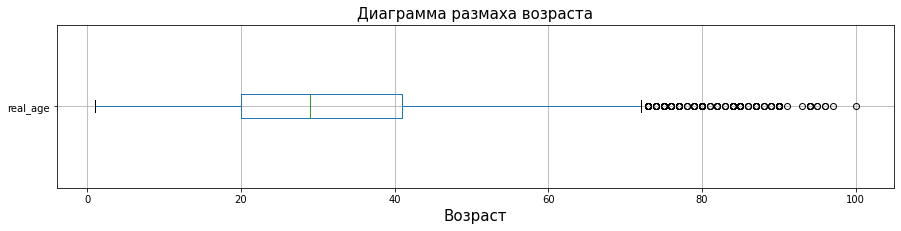

In [ ]:
# построим диаграмму размаха для возраста

labels.boxplot('real_age', figsize=(15,3), vert=False)
plt.title("Диаграмма размаха возраста", fontsize=15)
plt.xlabel("Возраст", fontsize=15);

Медиана 29 лет. Примерно после 73 лет начинаются выбросы.

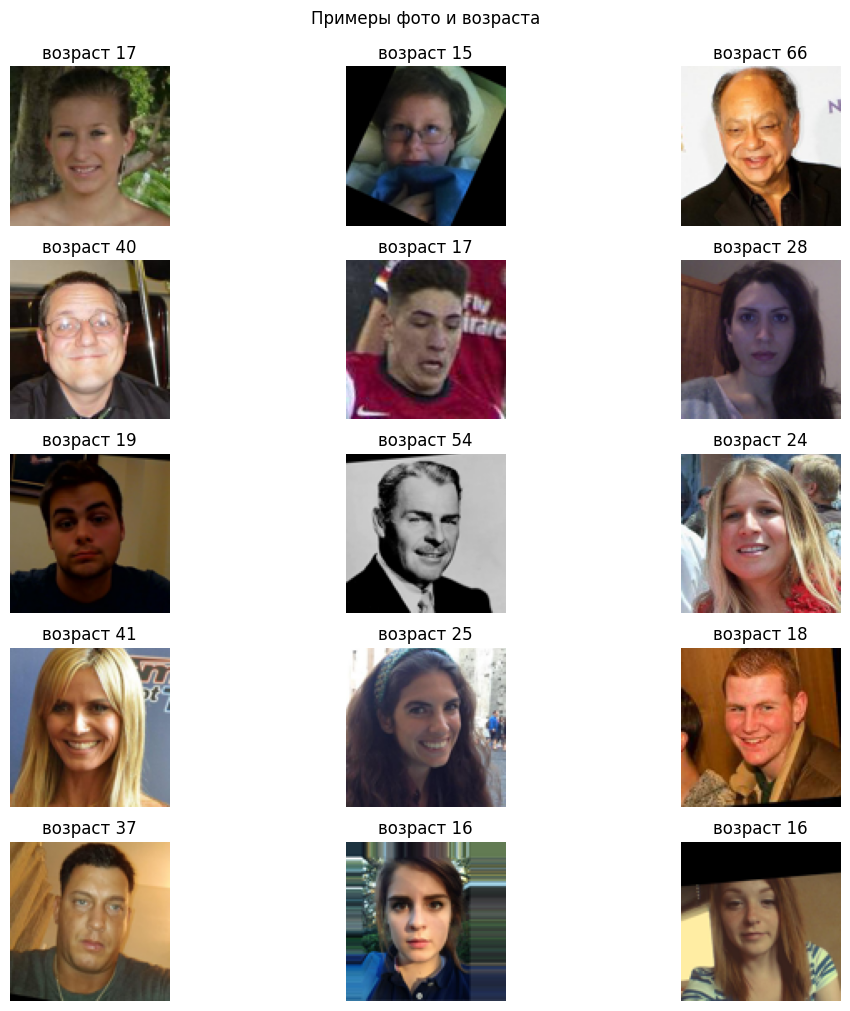

In [ ]:
# выведем 15 случайных изображений

fig, axs = plt.subplots(5, 3, sharey=True, constrained_layout=True,\
                        num=None, figsize=(10, 10), dpi=100, edgecolor='k')
fig.suptitle('Примеры фото и возраста')
axs = axs.flatten()

for i in range(15):
    idx = random.randint(0, len(labels)-1)
    image = Image.open('/datasets/faces/final_files/' + labels['file_name'][idx])
    image = image.resize((96,96))
    axs[i].imshow(image)
    axs[i].set_title('возраст ' + str(labels['real_age'][idx]))
    axs[i].axis('off')

Можно заменить, что выборка содержит уже скошенные фото, а также черно-белые изображения.

**Вывод**

Исследуемый датасет состоит из 7591 фото. Людям на фото от 1 до 100 лет. Медиана 29 лет. Примерно после 73 лет начинаются выбросы. Возраст в выборке распределен нормально с хвостом справа. Заметны две моды в районе 25 и 30 лет. Можно переходить к обучению модели.

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, AvgPool2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50

optimizer = Adam(learning_rate = 0.0001)

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
                                    validation_split=0.25,
                                    rescale=1./255,
                                    horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
      dataframe=labels,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=16,
      class_mode='raw',
      subset='training',
      seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
                                    validation_split=0.25,
                                    rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
      dataframe=labels,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=16,
      class_mode='raw',
      subset='validation',
      seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
			weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
			include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
```

```
Epoch 1/10
356/356 - 69s - loss: 211.8408 - mae: 10.5879 - val_loss: 600.4969 - val_mae: 19.3768
Epoch 2/10
356/356 - 57s - loss: 86.5515 - mae: 7.0711 - val_loss: 113.3158 - val_mae: 7.9938
Epoch 3/10
356/356 - 40s - loss: 56.6326 - mae: 5.7440 - val_loss: 75.5590 - val_mae: 6.5122
Epoch 4/10
356/356 - 42s - loss: 44.2515 - mae: 5.0865 - val_loss: 74.1264 - val_mae: 6.3166
Epoch 5/10
356/356 - 60s - loss: 33.1286 - mae: 4.4239 - val_loss: 74.2903 - val_mae: 6.5198
Epoch 6/10
356/356 - 67s - loss: 24.8342 - mae: 3.8397 - val_loss: 95.1267 - val_mae: 7.4260
Epoch 7/10
356/356 - 83s - loss: 18.5702 - mae: 3.2934 - val_loss: 74.4135 - val_mae: 6.3228
Epoch 8/10
356/356 - 73s - loss: 17.4550 - mae: 3.1739 - val_loss: 71.8803 - val_mae: 6.3121
Epoch 9/10
356/356 - 60s - loss: 14.5835 - mae: 2.9466 - val_loss: 80.4668 - val_mae: 6.6400
Epoch 10/10
356/356 - 57s - loss: 13.2348 - mae: 2.7809 - val_loss: 62.7962 - val_mae: 6.0141
```

## Анализ обученной модели

В нашем распоряжении 7591 фото людей в возрасте от 1 до 100 лет. Медианный возраст 29 лет, после 73 лет уже идут редкие значения. Распределение возраста нормальное с хвостом справа. Две моды - 25 и 30 лет. В качестве основы для модели была взята готовая модель ResNet50. Алгоритм оптимизации Adam(learning_rate = 0.0001). Обучение проходило на 10 эпохах. Результат модели на тестовой выборке 6.0141 (минимальное требование MAE = 8 выполнено).